[View in Colaboratory](https://colab.research.google.com/github/shashank2806/mnist-digits-classifiers/blob/master/convolutional_neural_network.ipynb)

#Convolutional Neural Network

We earlier used linear model on mnist data and got around 92% test accuracy.

In this notebook we will implement CNN in TensorFlow for classification.

##Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

This notebook was developed using Google Colab using python 3.6 and TensorFlow version:

In [27]:
tf.__version__

'1.10.0'

###Load Data

In [28]:
# workaround for google colab
import os
work_dir = "/content/mnist-digits-classifiers/" 
if os.getcwd() != work_dir:
  !git clone https://github.com/shashank2806/mnist-digits-classifiers
os.chdir(work_dir)


Cloning into 'mnist-digits-classifiers'...
remote: Counting objects: 49, done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 49 (delta 25), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [0]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

In [30]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [31]:
# The number of pixels in each dimension of an image.
img_size = data.img_size

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = data.num_channels

img_size, img_size_flat, img_shape, num_channels

(28, 784, (28, 28), 1)

###Helper function for plotting Image

In [0]:
# https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/01_Simple_Linear_Model.ipynb
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Plot few Images

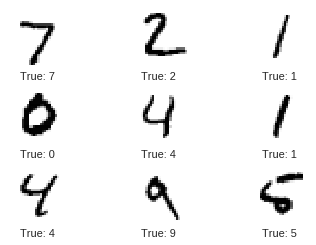

In [33]:
images = data.x_test[0:9]
cls_true = data.y_test_cls[0:9]
plot_images(images=images, cls_true=cls_true)

##TF Graph

We are going to build a CNN with 2 Conv layers, and 1 fully connected layer having following dimensions.

In [0]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

Function for new weights and biases using Xavier initialization

In [0]:
def new_weights(shape):
#   return tf.Variable(tf.contrib.layers.xavier_initializer(shape))
  return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

Function of creating new conv layer.

In [0]:
def new_conv_layer(input,
                  num_input_channels,
                  filter_size,
                  num_filters,
                  use_pooling=True):
  # Shape of filter weights for convolution
  # Format determined by TensorFlow API
  shape = [filter_size, filter_size, num_input_channels, num_filters]
  
  # create new weights with given shape
  weights = new_weights(shape=shape)
  
  # create biases, one for each filter
  biases = new_biases(length=num_filters)
  
  # stride = 1, padding = SAME
  layer = tf.nn.conv2d(input=input,
                      filter=weights,
                      strides=[1,1,1,1],
                      padding='SAME')
  
  # A bias-value is added to each filter-channel.
  layer += biases
  
  # 2*2 max pooling with stride of 2 
  if use_pooling:
    layer = tf.nn.max_pool(value=layer,
                          ksize=[1,2,2,1],   # for 2*2 pooling
                          strides=[1,2,2,1],  # for stride of 2
                          padding='SAME')
    
  # add relu non-linearity
  layer = tf.nn.relu(layer)
  
  return layer

###Function for flattening a layer

In [0]:
def flatten_layer(layer):
  layer_shape = layer.get_shape()
  
  # layer_shape == [num_images, img_height, img_width, num_channels]
  num_features = layer_shape[1:4].num_elements()
  
  # reshape layer to (num_images, img_height * img_width * num_channels)
  layer_flat = tf.reshape(layer, [-1, num_features])
  
  return layer_flat, num_features

### Function for fully connected layer

In [0]:
def new_fc_layer(input,
                num_inputs,
                num_outputs,
                use_relu=True):
  
  weights = new_weights(shape=[num_inputs, num_outputs])
  biases = new_biases(length=num_outputs)
  
  layer = tf.matmul(input, weights) + biases
  
  if use_relu:
    layer = tf.nn.relu(layer)
    
  return layer

###Placeholder Variable

In [0]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat])

In [0]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [0]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes])

In [0]:
y_true_cls = tf.argmax(y_true, axis=1)

###Conv layer 1

In [0]:
# conv layer 1
layer_conv1 = new_conv_layer(input=x_image,
                            num_input_channels=num_channels,
                            filter_size=filter_size1,
                            num_filters=num_filters1,
                            use_pooling=True)

In [46]:
# size of output of conv layer 1
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

###Conv Layer 2

In [0]:
# Conv layer 2
layer_conv2 = new_conv_layer(input=layer_conv1,
                            num_input_channels=num_filters1,
                            filter_size=filter_size2,
                            num_filters=num_filters2,
                            use_pooling=True)

In [49]:
# size of output of conv layer 2
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

###Flatten Layer

In [0]:
# Flatten layers for feeding in fully connected layer
layer_flat, num_features = flatten_layer(layer_conv2)

In [52]:
layer_flat

<tf.Tensor 'Reshape_2:0' shape=(?, 1764) dtype=float32>

In [53]:
num_features

1764

###Fully connected layer 1

In [0]:
layer_fc1 = new_fc_layer(input=layer_flat,
                        num_inputs=num_features,
                        num_outputs=fc_size,
                        use_relu=True)

In [64]:
layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 128) dtype=float32>

###Fully connected layer 2

In [0]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                        num_inputs=fc_size,
                        num_outputs=num_classes,
                        use_relu=False)

In [66]:
layer_fc2

<tf.Tensor 'add_5:0' shape=(?, 10) dtype=float32>